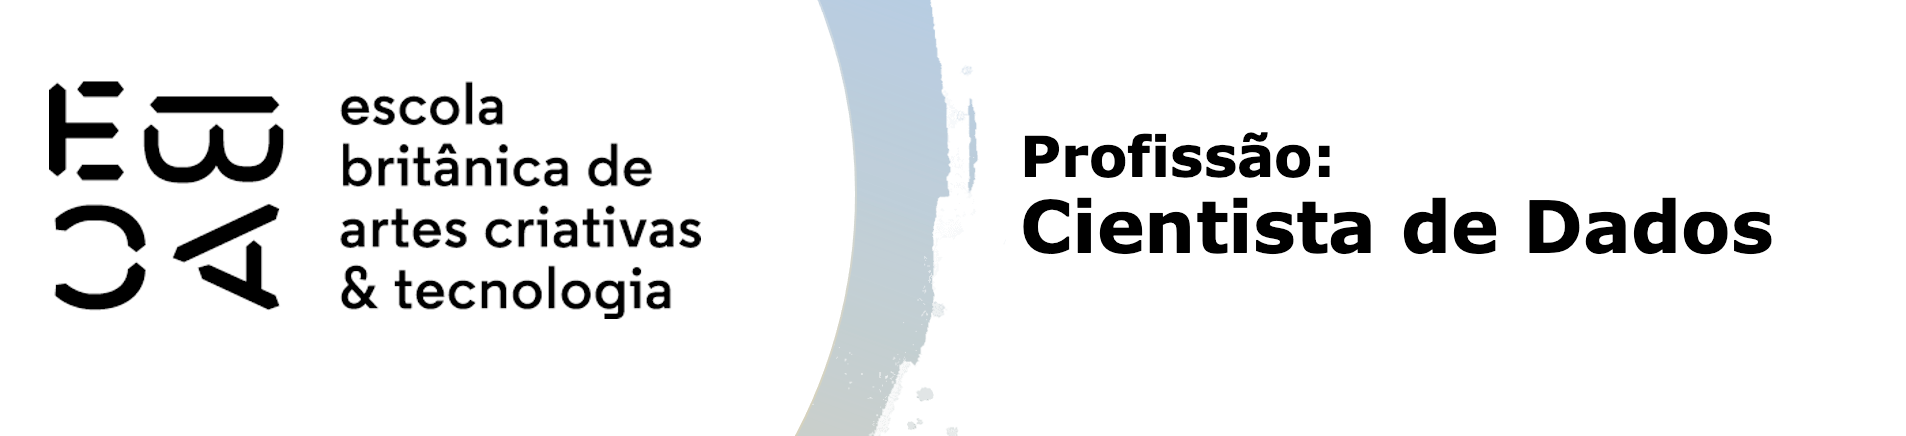

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from scipy.stats import ks_2samp
from scipy.stats import t

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from pycaret.classification import *

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer

sns.set_palette('colorblind')

%matplotlib inline
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [8]:
# tratando os dados:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

In [9]:
print(df.data_ref.min())
print(df.data_ref.max())

2015-01-01 00:00:00
2016-03-01 00:00:00


In [10]:
df.set_index('data_ref', inplace=True)
df.drop(['index'], axis=1, inplace=True)
df.head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
data_ref,,,,,,,,,,,,,
2015-01-01,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
2015-01-01,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2015-01-01,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
2015-01-01,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
2015-01-01,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [11]:
# separando a base de dados e de treino:

df_train = df['2015-01-01':'2015-12-01']
df_test = df['2016-01-01':]

In [12]:
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [13]:
df_train['mes'] = df_train['data_ref'].dt.month
warnings.filterwarnings(action ='ignore')
df_train

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,mes
0,2015-01-01,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False,1
1,2015-01-01,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False,1
2,2015-01-01,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False,1
3,2015-01-01,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False,1
4,2015-01-01,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,2015-12-01,F,S,N,0,Assalariado,Médio,União,Casa,47,23.690411,2.0,11009.92,False,12
599996,2015-12-01,M,S,N,1,Empresário,Superior completo,Casado,Casa,31,3.756164,3.0,4472.60,False,12
599997,2015-12-01,F,N,N,0,Pensionista,Médio,Casado,Casa,62,NaN,2.0,5117.17,True,12
599998,2015-12-01,F,N,N,0,Assalariado,Superior completo,Casado,Casa,40,12.939726,2.0,2885.45,True,12


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [14]:
df_train['mes'].value_counts(ascending=True)

1     50000
2     50000
3     50000
4     50000
5     50000
6     50000
7     50000
8     50000
9     50000
10    50000
11    50000
12    50000
Name: mes, dtype: int64

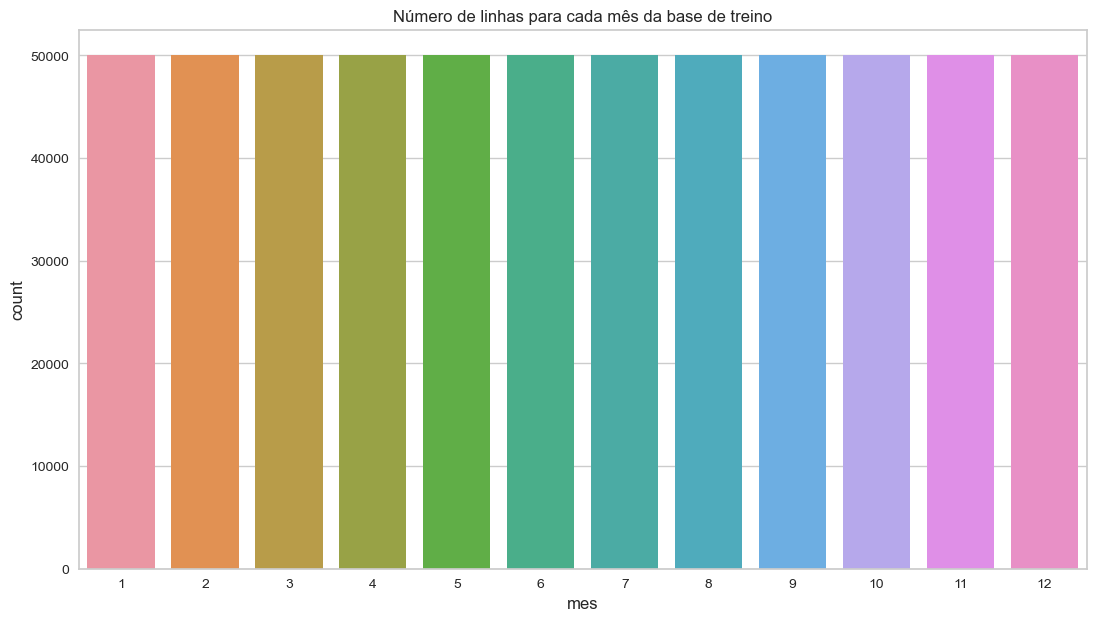

In [15]:
fig, ax = plt.subplots(figsize=(13, 7))
sns.countplot(data=df_train, x='mes', ax=ax)
ax.set_title('Número de linhas para cada mês da base de treino');

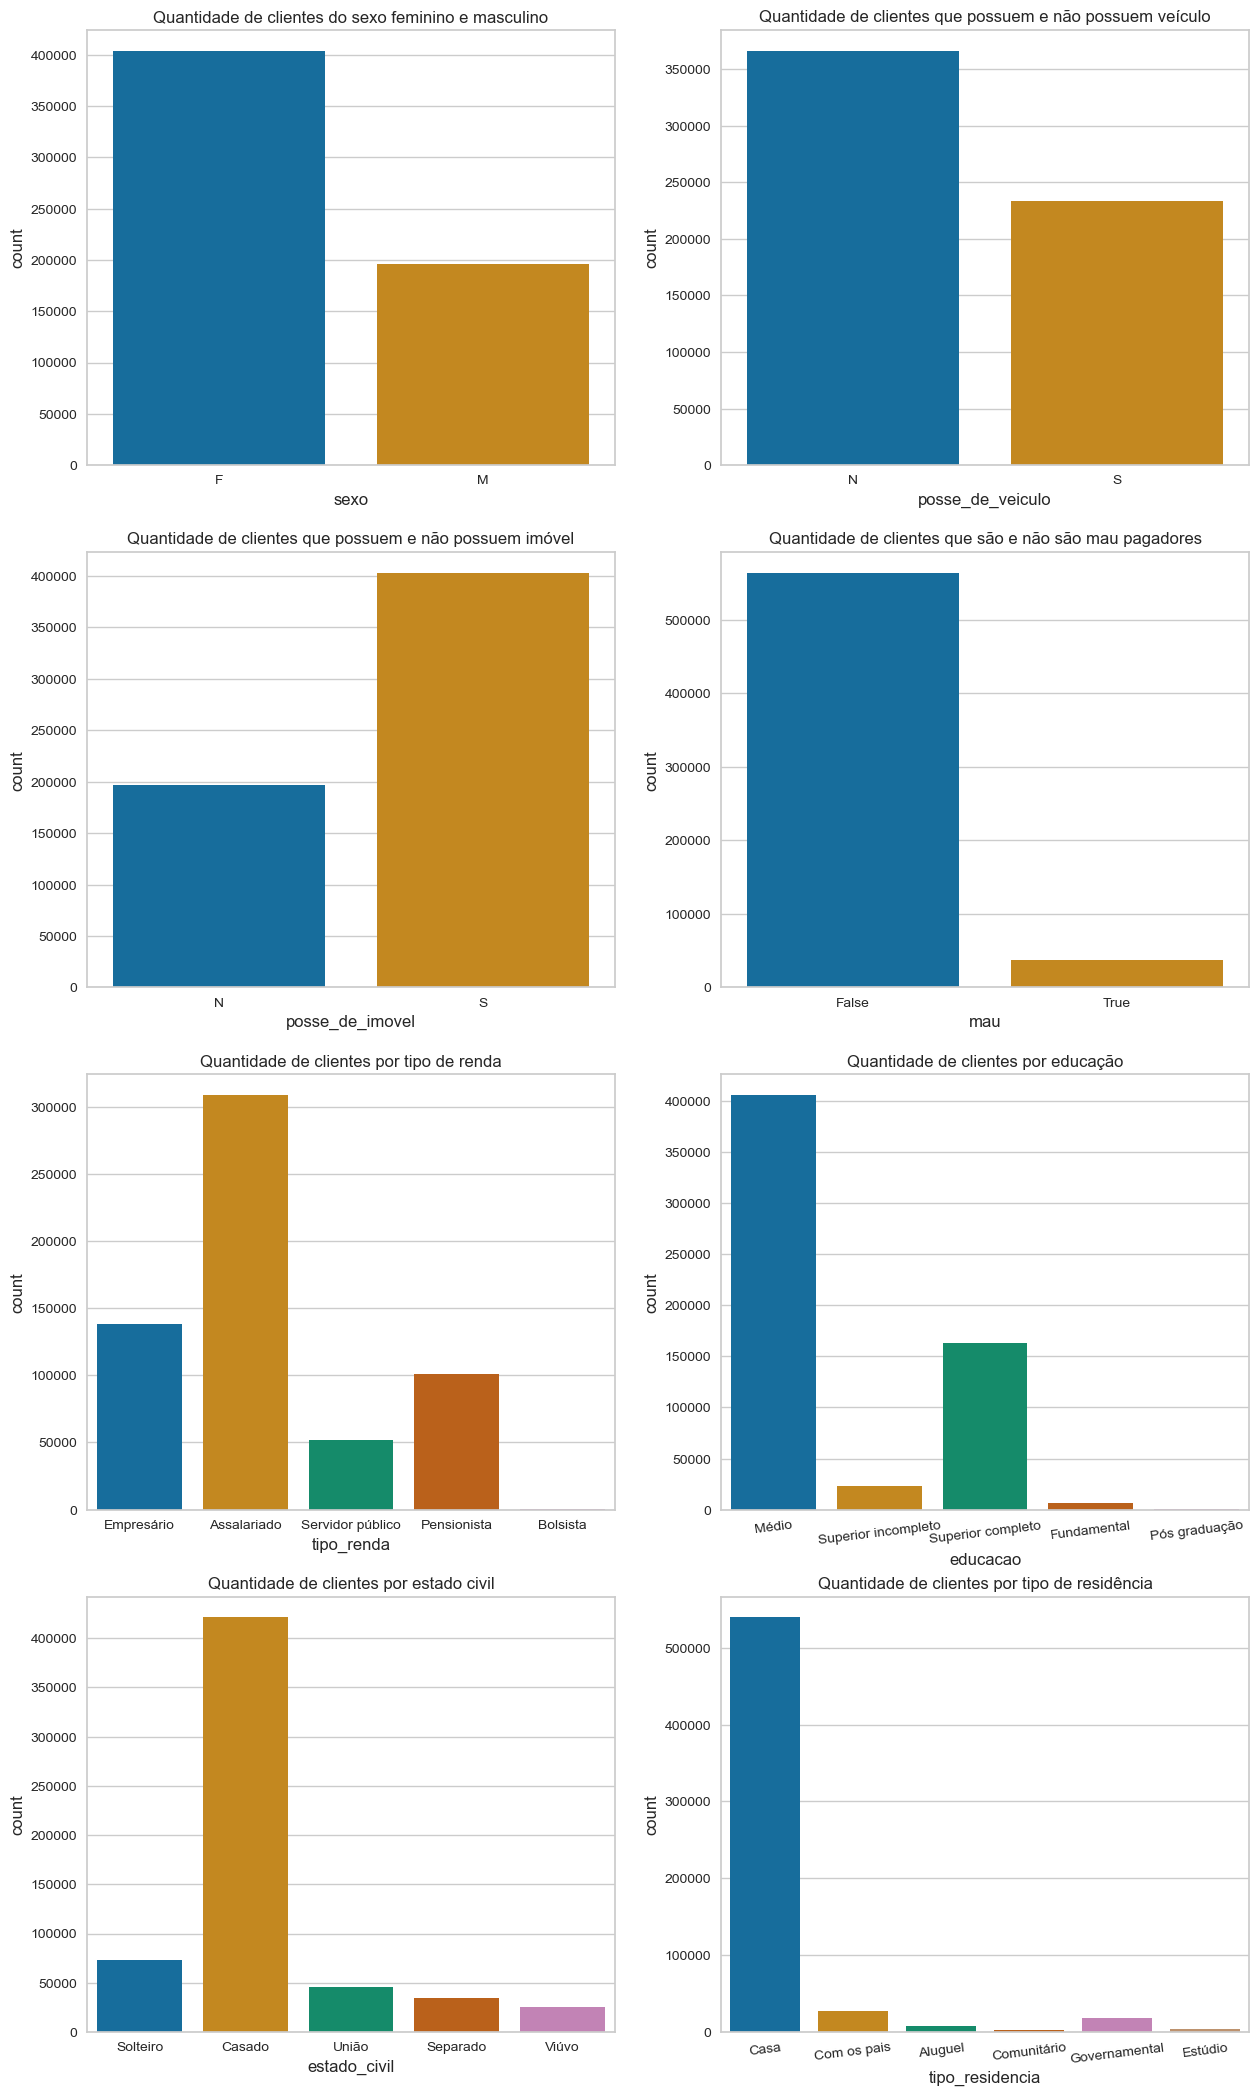

In [16]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15,26))

sns.countplot(data=df_train, x='sexo', ax=ax[0,0])
ax[0,0].set_title('Quantidade de clientes do sexo feminino e masculino')

sns.countplot(data=df_train, x='posse_de_veiculo', ax=ax[0,1])
ax[0,1].set_title('Quantidade de clientes que possuem e não possuem veículo')

sns.countplot(data=df_train, x='posse_de_imovel', ax=ax[1,0])
ax[1,0].set_title('Quantidade de clientes que possuem e não possuem imóvel')

sns.countplot(data=df_train, x='mau', ax=ax[1,1])
ax[1,1].set_title('Quantidade de clientes que são e não são mau pagadores')

sns.countplot(data=df_train, x='tipo_renda', ax=ax[2,0])
ax[2,0].set_title('Quantidade de clientes por tipo de renda')

sns.countplot(data=df_train, x='educacao', ax=ax[2,1])
ax[2,1].set_title('Quantidade de clientes por educação')
for tick in ax[2,1].get_xticklabels():
    tick.set_rotation(7)

sns.countplot(data=df_train, x='estado_civil', ax=ax[3,0])
ax[3,0].set_title('Quantidade de clientes por estado civil')

sns.countplot(data=df_train, x='tipo_residencia', ax=ax[3,1])
ax[3,1].set_title('Quantidade de clientes por tipo de residência')
for tick in ax[3,1].get_xticklabels():
    tick.set_rotation(7);

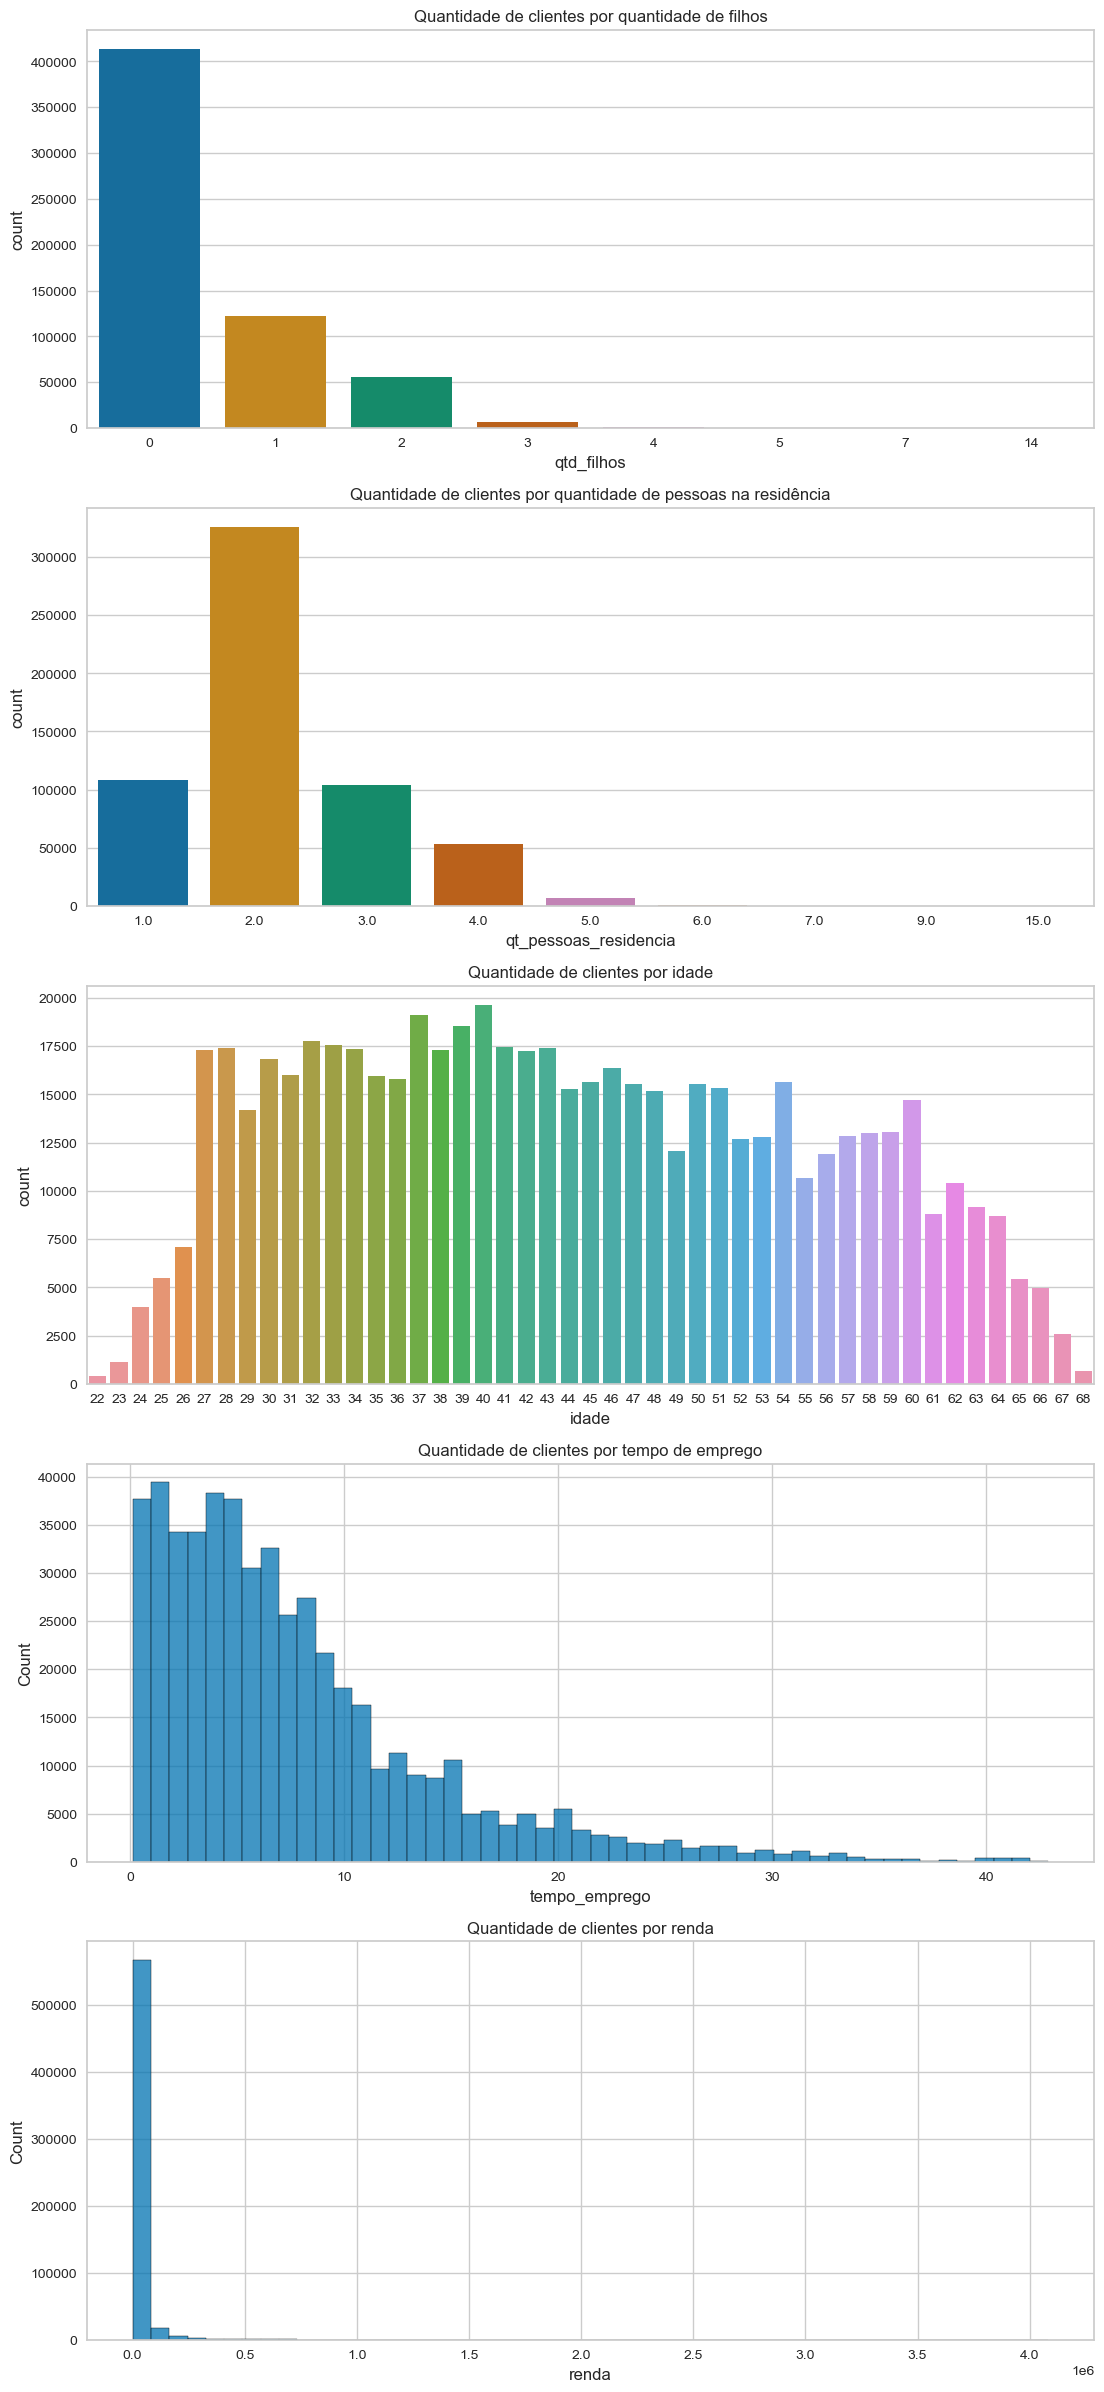

In [20]:
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(13,30))

sns.countplot(data=df_train, x='qtd_filhos', ax=ax[0])
ax[0].set_title('Quantidade de clientes por quantidade de filhos')

sns.countplot(data=df_train, x='qt_pessoas_residencia', ax=ax[1])
ax[1].set_title('Quantidade de clientes por quantidade de pessoas na residência')

sns.countplot(data=df_train, x='idade', ax=ax[2])
ax[2].set_title('Quantidade de clientes por idade')

sns.histplot(data=df_train, x='tempo_emprego', bins=50, ax=ax[3])
ax[3].set_title('Quantidade de clientes por tempo de emprego')

sns.histplot(data=df_train, x='renda', bins=50, ax=ax[4])
ax[4].set_title('Quantidade de clientes por renda');

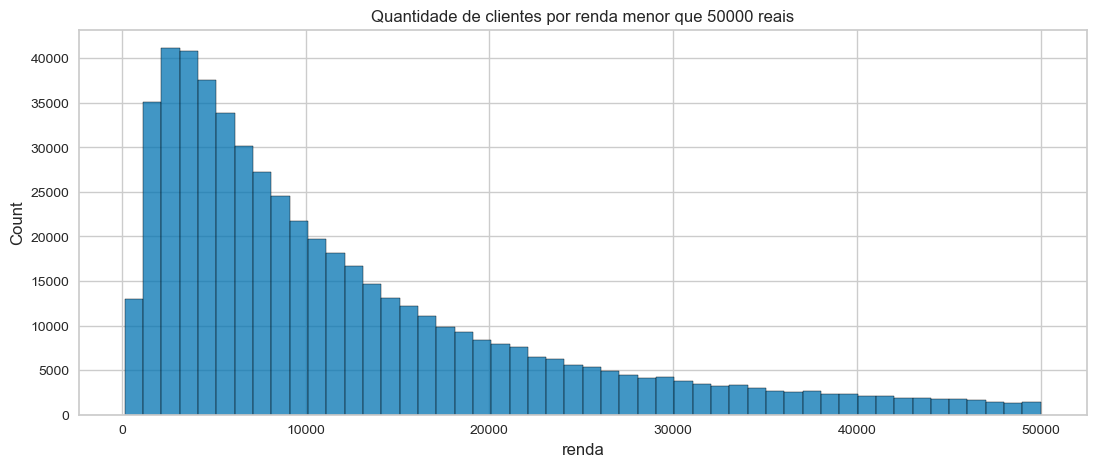

In [21]:
fig, ax = plt.subplots(figsize=(13,5))

sns.histplot(data=df_train[df_train.renda<50000], x='renda', bins=50, ax=ax)
ax.set_title('Quantidade de clientes por renda menor que 50000 reais');

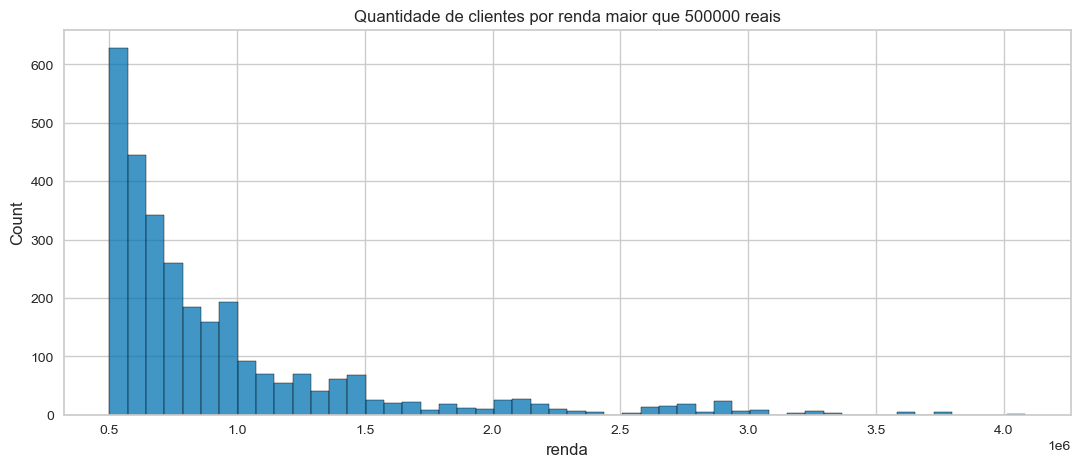

In [22]:
fig, ax = plt.subplots(figsize=(13,5))

sns.histplot(data=df_train[df_train.renda>500000], x='renda', bins=50, ax=ax)
ax.set_title('Quantidade de clientes por renda maior que 500000 reais');

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

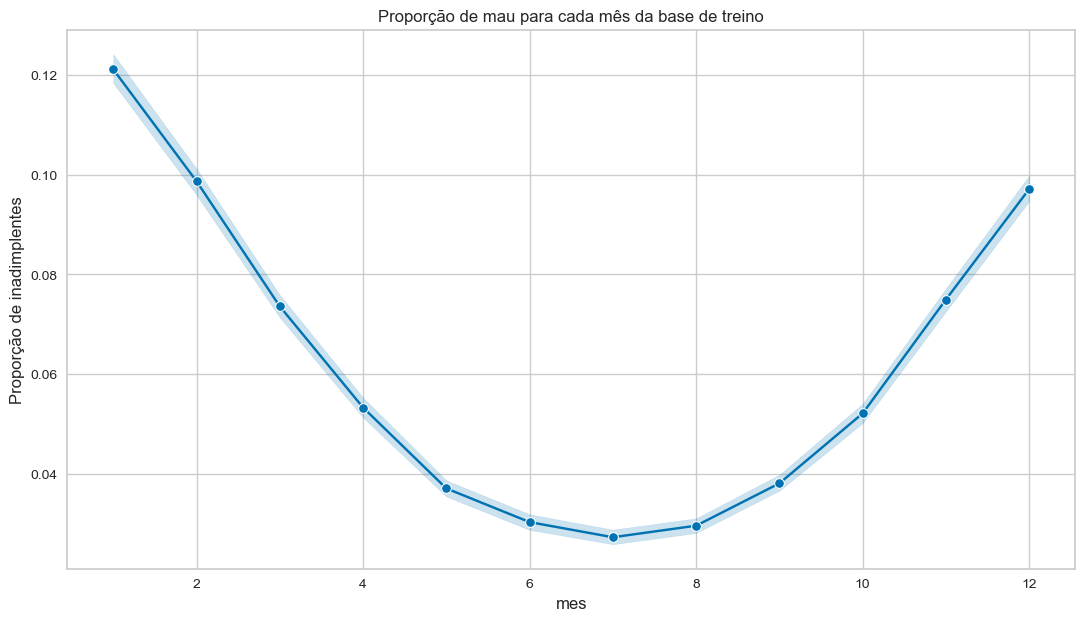

In [23]:
fig, ax = plt.subplots(figsize=(13,7))
sns.lineplot(data=df_train, x='mes', y='mau', ax=ax, marker='o')
ax.set_title('Proporção de mau para cada mês da base de treino')
ax.set_ylabel("Proporção de inadimplentes");

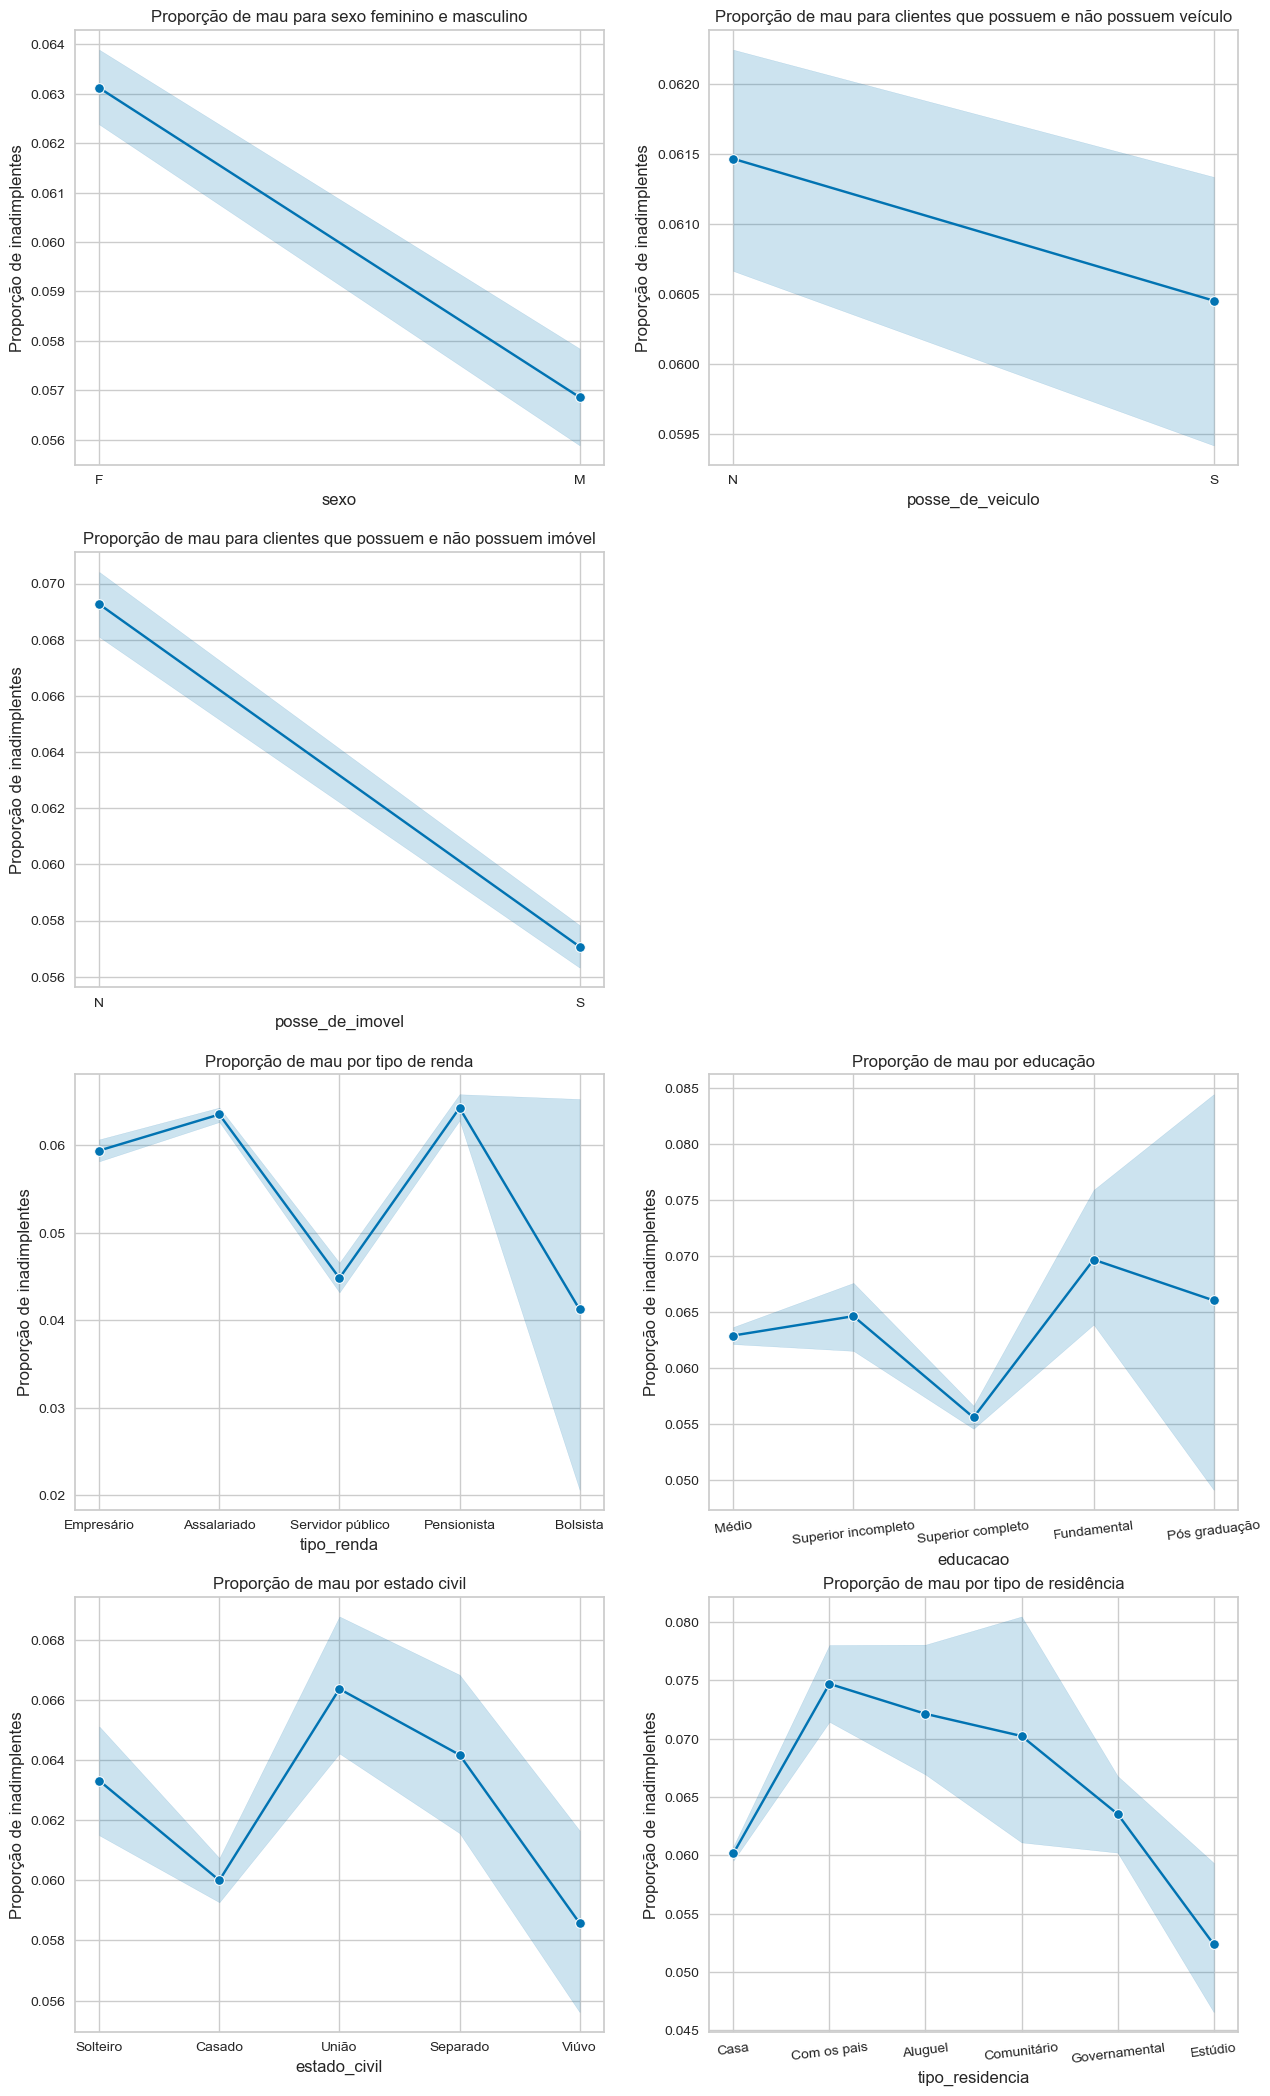

In [24]:
ig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 26))

sns.lineplot(data=df_train, x='sexo', y='mau', ax=ax[0, 0], marker='o')
ax[0, 0].set_title('Proporção de mau para sexo feminino e masculino')
ax[0, 0].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df_train, x='posse_de_veiculo', y='mau', ax=ax[0, 1], marker='o')
ax[0, 1].set_title('Proporção de mau para clientes que possuem e não possuem veículo')
ax[0, 1].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df_train, x='posse_de_imovel', y='mau', ax=ax[1, 0], marker='o')
ax[1, 0].set_title('Proporção de mau para clientes que possuem e não possuem imóvel')
ax[1, 0].set_ylabel("Proporção de inadimplentes")

ax[1, 1].axis('off')

sns.lineplot(data=df_train, x='tipo_renda', y='mau', ax=ax[2, 0], marker='o')
ax[2, 0].set_title('Proporção de mau por tipo de renda')
ax[2, 0].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df_train, x='educacao', y='mau', ax=ax[2, 1], marker='o')
ax[2, 1].set_title('Proporção de mau por educação')
ax[2, 1].set_ylabel("Proporção de inadimplentes")
for tick in ax[2, 1].get_xticklabels():
    tick.set_rotation(7)

sns.lineplot(data=df_train, x='estado_civil', y='mau', ax=ax[3, 0], marker='o')
ax[3, 0].set_title('Proporção de mau por estado civil')
ax[3, 0].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df_train, x='tipo_residencia', y='mau', ax=ax[3, 1], marker='o')
ax[3, 1].set_title('Proporção de mau por tipo de residência')
ax[3, 1].set_ylabel("Proporção de inadimplentes")
for tick in ax[3, 1].get_xticklabels():
    tick.set_rotation(7);

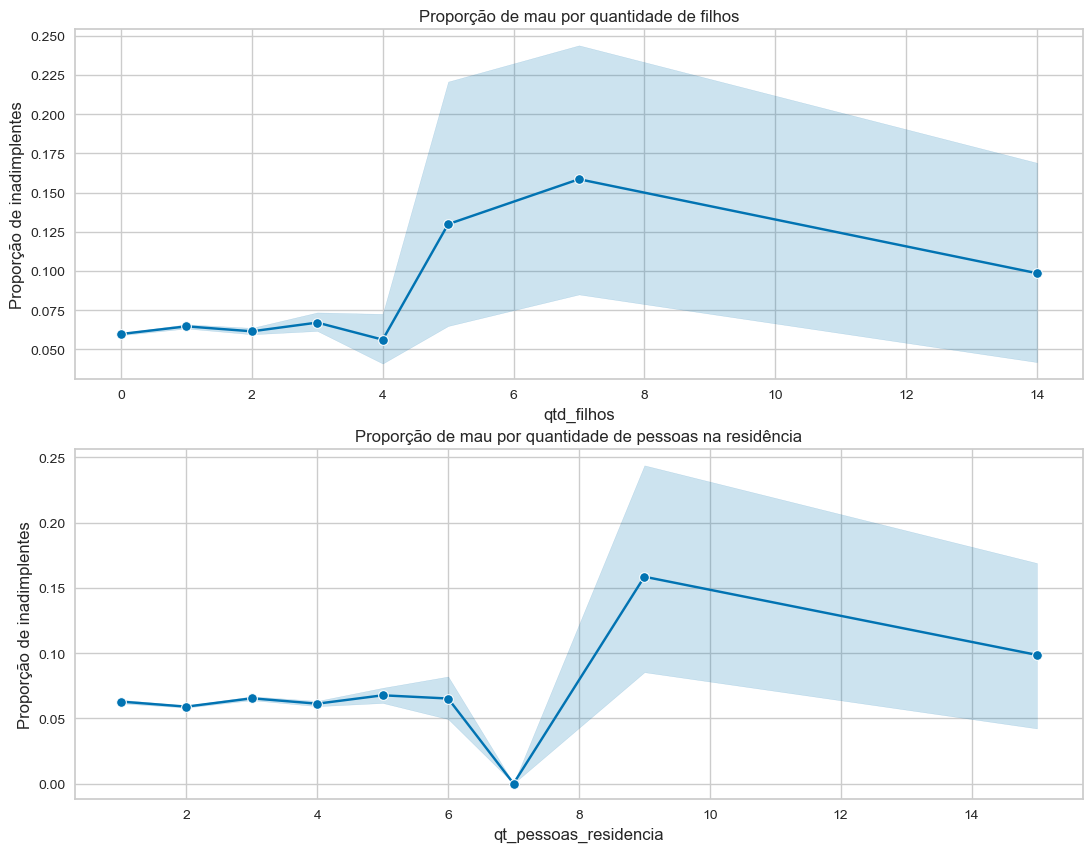

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(13, 10))

sns.lineplot(data=df_train, x='qtd_filhos', y='mau', ax=ax[0], marker='o')
ax[0].set_title('Proporção de mau por quantidade de filhos')
ax[0].set_ylabel("Proporção de inadimplentes")

sns.lineplot(data=df_train, x='qt_pessoas_residencia', y='mau', ax=ax[1], marker='o')
ax[1].set_title('Proporção de mau por quantidade de pessoas na residência')
ax[1].set_ylabel("Proporção de inadimplentes");

Text(0.5, 1.0, 'Proporção de mau para intervalos de idade')

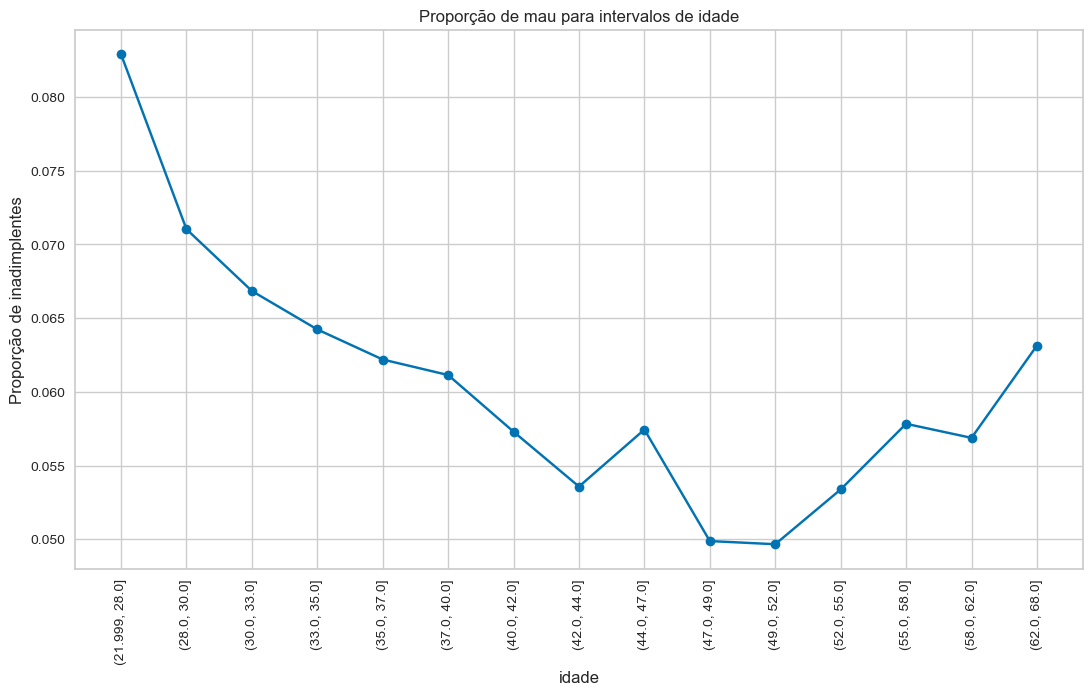

In [26]:
fig, ax = plt.subplots(figsize=(13, 7))

cat_1, bins = pd.qcut(df_train['idade'], 15, retbins=True)
df_1 = df_train.groupby(cat_1)
biv = df_1['mau'].mean()

ax = biv.plot.line(marker='o')
ax.set_ylabel("Proporção de inadimplentes")
ticks = plt.xticks(range(len(biv.index.values)), biv.index.values, rotation=90)
ax.set_title('Proporção de mau para intervalos de idade')

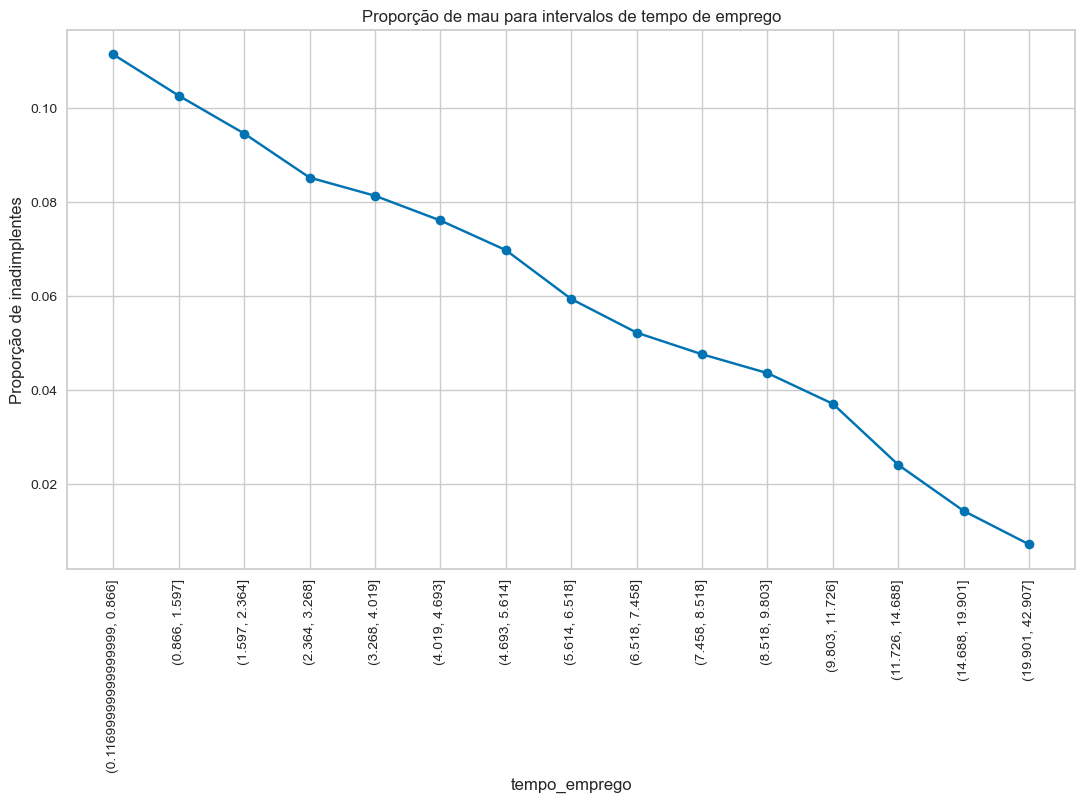

In [27]:
fig, ax = plt.subplots(figsize=(13, 7))

cat_1, bins = pd.qcut(df_train['tempo_emprego'], 15, retbins=True)
df_1 = df_train.groupby(cat_1)
biv = df_1['mau'].mean()

ax = biv.plot.line(marker='o')
ax.set_ylabel("Proporção de inadimplentes")
ticks = plt.xticks(range(len(biv.index.values)), biv.index.values, rotation=90)
ax.set_title('Proporção de mau para intervalos de tempo de emprego');

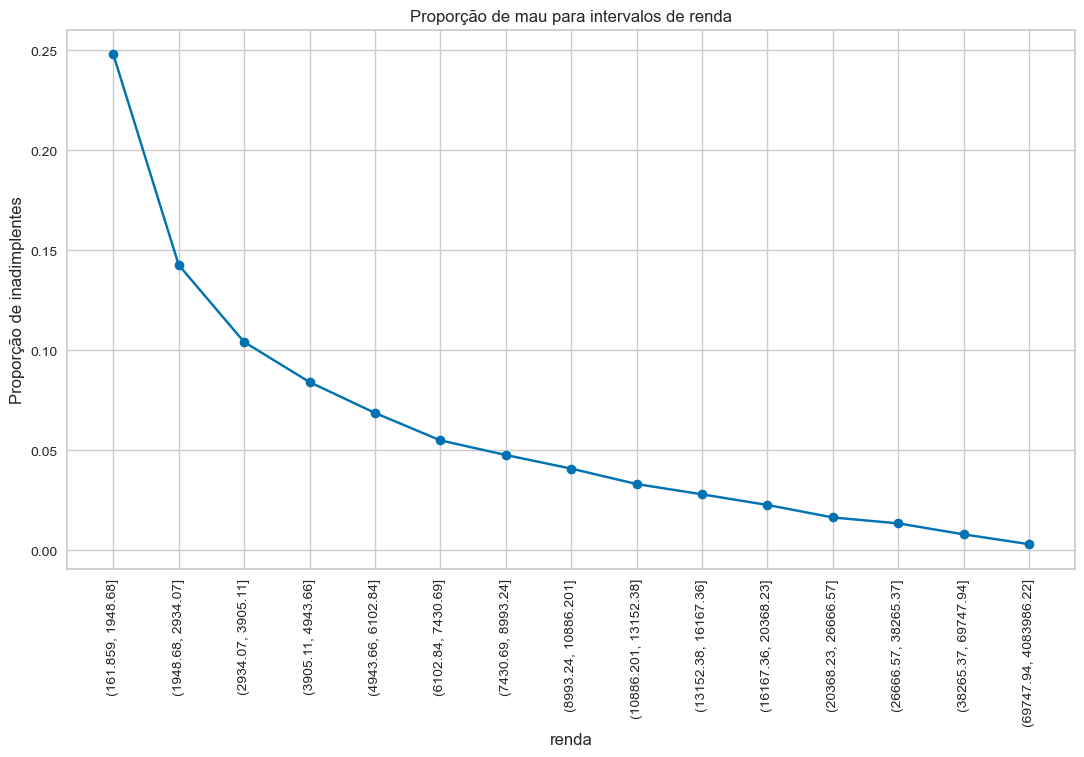

In [28]:
fig, ax = plt.subplots(figsize=(13, 7))

cat_1, bins = pd.qcut(df_train['renda'], 15, retbins=True)
df_1 = df_train.groupby(cat_1)
biv = df_1['mau'].mean()

ax = biv.plot.line(marker='o')
ax.set_ylabel("Proporção de inadimplentes")
ticks = plt.xticks(range(len(biv.index.values)), biv.index.values, rotation=90)
ax.set_title('Proporção de mau para intervalos de renda');

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [29]:
# tratando dados missing (substituindo pela média)

df_train['mau'] = df_train.mau.astype('int64')
df_train.drop(columns = ['data_ref', 'mes'], inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sexo                   600000 non-null  object 
 1   posse_de_veiculo       600000 non-null  object 
 2   posse_de_imovel        600000 non-null  object 
 3   qtd_filhos             600000 non-null  int64  
 4   tipo_renda             600000 non-null  object 
 5   educacao               600000 non-null  object 
 6   estado_civil           600000 non-null  object 
 7   tipo_residencia        600000 non-null  object 
 8   idade                  600000 non-null  int64  
 9   tempo_emprego          499125 non-null  float64
 10  qt_pessoas_residencia  600000 non-null  float64
 11  renda                  600000 non-null  float64
 12  mau                    600000 non-null  int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 59.5+ MB


In [30]:
df_train['tempo_emprego'].fillna(value=df_train['tempo_emprego'].mean(), inplace=True);

metadados = pd.DataFrame(df_train.dtypes, columns=['dtype'])
metadados['nmissing'] = df_train.isna().sum()
metadados['valores_unicos'] = df_train.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados

,dtype,nmissing,valores_unicos,papel
sexo,object,0,2,covariavel
posse_de_veiculo,object,0,2,covariavel
posse_de_imovel,object,0,2,covariavel
qtd_filhos,int64,0,8,covariavel
tipo_renda,object,0,5,covariavel
educacao,object,0,5,covariavel
estado_civil,object,0,5,covariavel
tipo_residencia,object,0,6,covariavel
idade,int64,0,47,covariavel
tempo_emprego,float64,0,3005,covariavel


In [31]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    tilo_evento = tab.columns[0]
    tilo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[tilo_evento]/tab.loc['total', tilo_evento]
    tab['ep'] = tab[tilo_evento]/tab.loc['total', tilo_evento]

    tab['pct_nao_evento'] = tab[tilo_nao_evento] / tab.loc['total', tilo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()


def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau': g['mau'].mean(),
                        var: g['mau'].mean().index,
                        'cont': g[var].count()})

    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep

    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')

    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)

    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=8)

    ax[1] = biv.cont.plot.bar()
    return biv


def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau': g['mau'].mean(),
                        var: g[var].mean(),
                        'cont': g[var].count()})

    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep

    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')

    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)

    ax[1] = biv.cont.plot.bar()
    return None

In [32]:
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>10):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df_train[var],5,duplicates='drop'), df_train.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(df_train[var], df_train.mau)
    
metadados

,dtype,nmissing,valores_unicos,papel,IV
sexo,object,0,2,covariavel,0.002665
posse_de_veiculo,object,0,2,covariavel,0.000075
posse_de_imovel,object,0,2,covariavel,0.009690
qtd_filhos,int64,0,8,covariavel,0.001689
tipo_renda,object,0,5,covariavel,0.009718
educacao,object,0,5,covariavel,0.003690
estado_civil,object,0,5,covariavel,0.001305
tipo_residencia,object,0,6,covariavel,0.003330
idade,int64,0,47,covariavel,0.018434
tempo_emprego,float64,0,3005,covariavel,0.283956


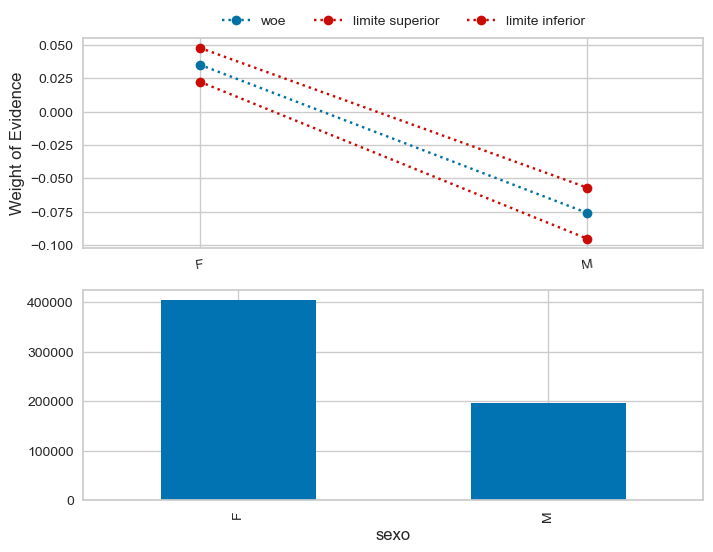

In [33]:
biv_discreta('sexo', df_train);

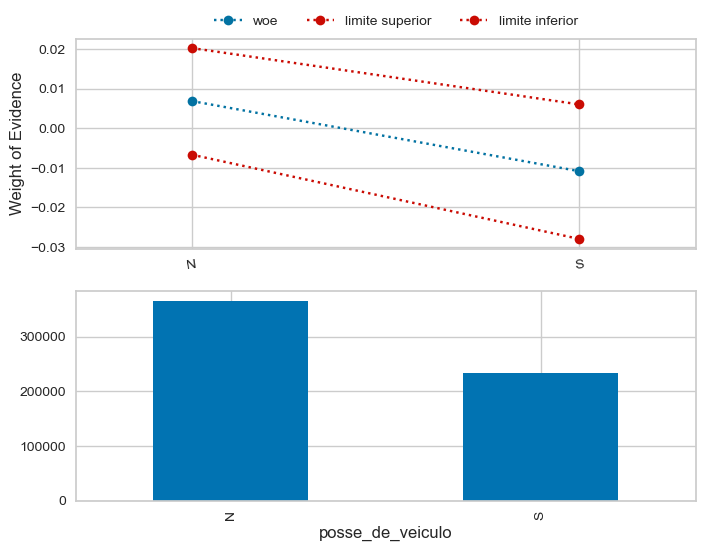

In [34]:
biv_discreta('posse_de_veiculo', df_train);

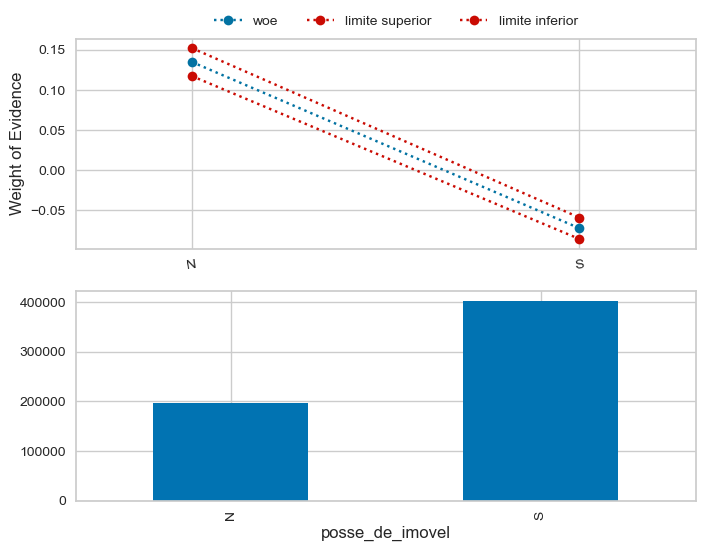

In [35]:
biv_discreta('posse_de_imovel', df_train);

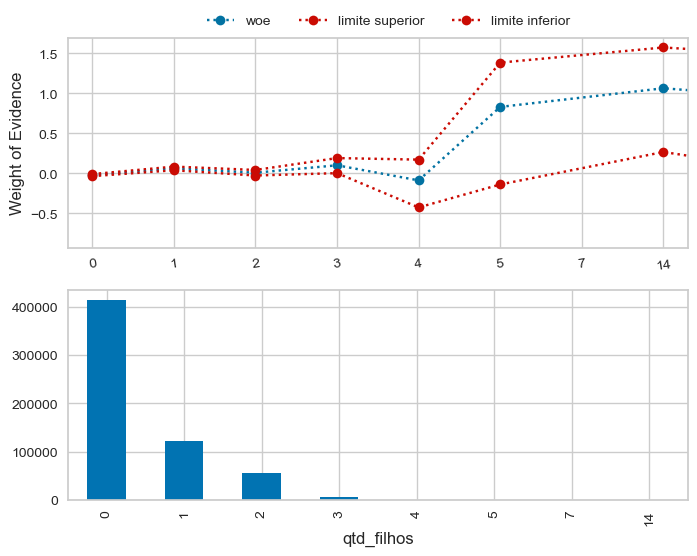

In [36]:
biv_discreta('qtd_filhos', df_train);

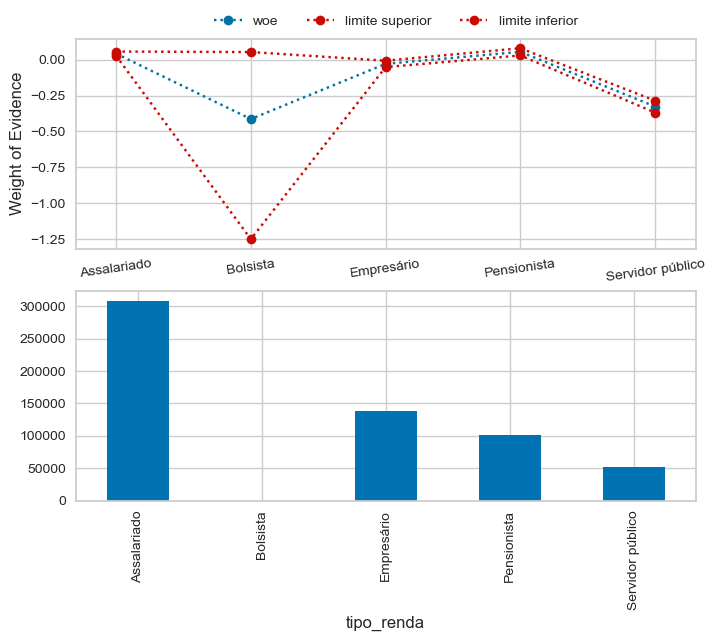

In [37]:
biv_discreta('tipo_renda', df_train);

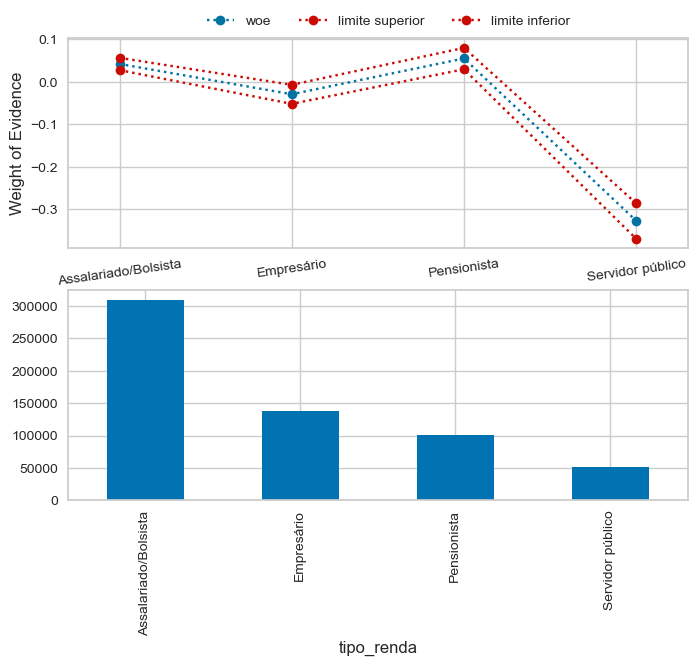

In [38]:
# Agrupando as classes da variável tipo renda

df_train.tipo_renda.replace({'Assalariado':'Assalariado/Bolsista', 
                      'Bolsista':'Assalariado/Bolsista',
                     }, inplace=True)

biv_discreta('tipo_renda', df_train);
IV(df_train.tipo_renda, df_train.mau);

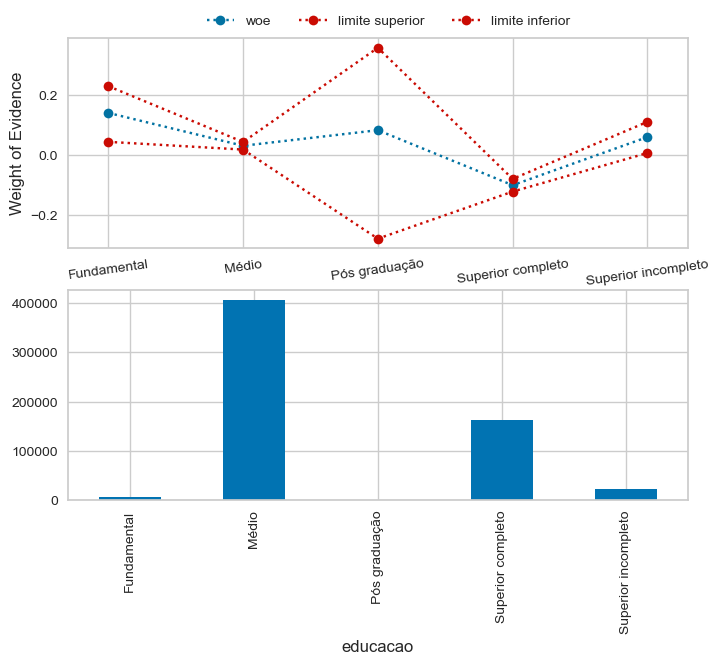

In [39]:
biv_discreta('educacao', df_train);

0.0034801108923340892

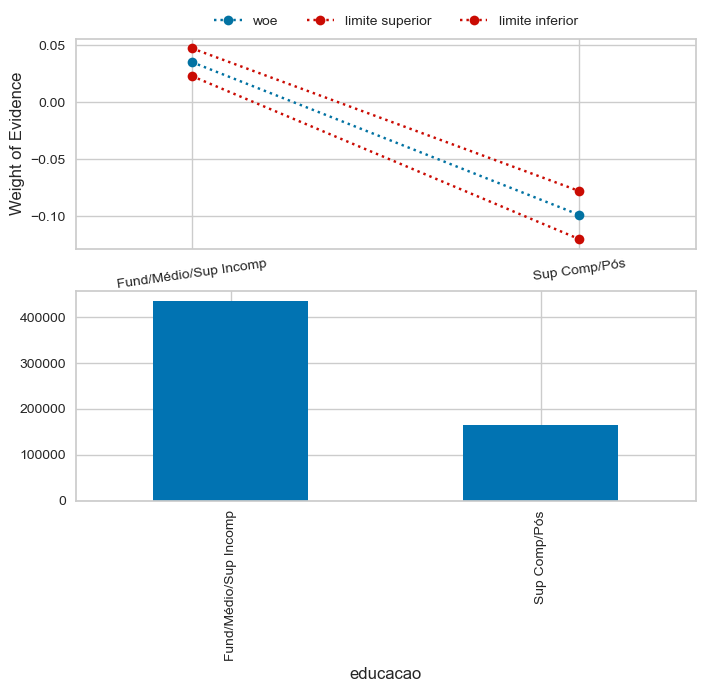

In [40]:
# Agrupando as classes da variável educacao

df_train.educacao.replace({'Fundamental':'Fund/Médio/Sup Incomp', 
                      'Médio':'Fund/Médio/Sup Incomp',
                      'Superior incompleto':'Fund/Médio/Sup Incomp',
                      'Superior completo': 'Sup Comp/Pós',
                      'Pós graduação': 'Sup Comp/Pós'
                     }, inplace=True)

biv_discreta('educacao', df_train);
IV(df_train.educacao, df_train.mau)

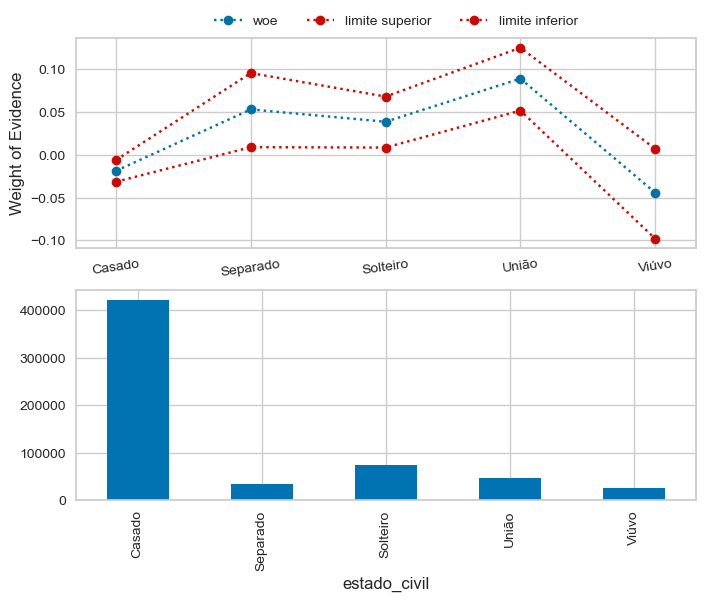

In [41]:
biv_discreta('estado_civil', df_train);

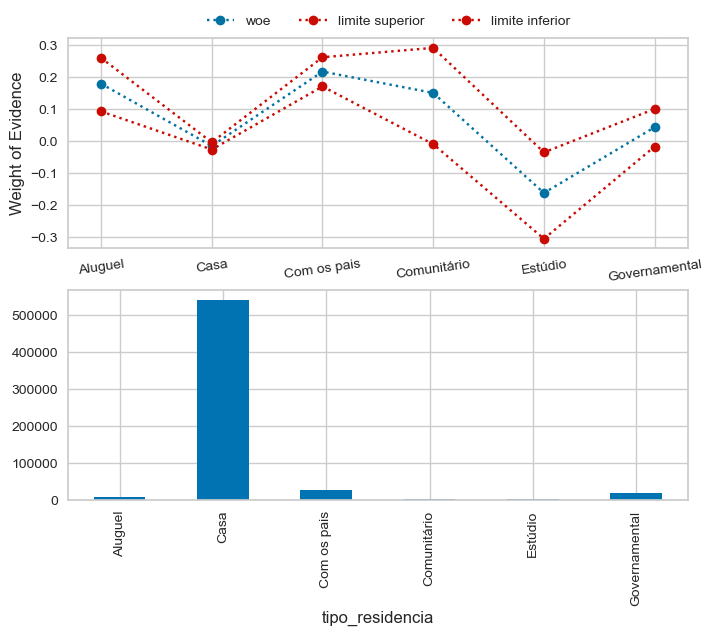

In [42]:
biv_discreta('tipo_residencia', df_train);

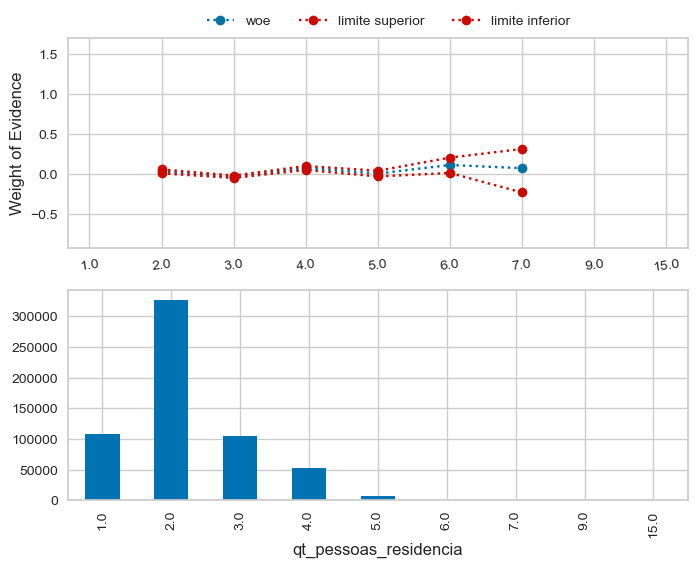

In [43]:
biv_discreta('qt_pessoas_residencia', df_train);

Comentário: Descobrimos zeros estruturais apenas na variável qt_pessoas_residencia, utilizando a informação obtida no gráfico bivariado da variável mau percebemos que a proporção de inadimplentes não aumenta ou diminui proporcionalmente com a variável qt_pessoas_residencia, então ao invés de tratar os zeros estruturais, apenas removerei esta variável do modelo.

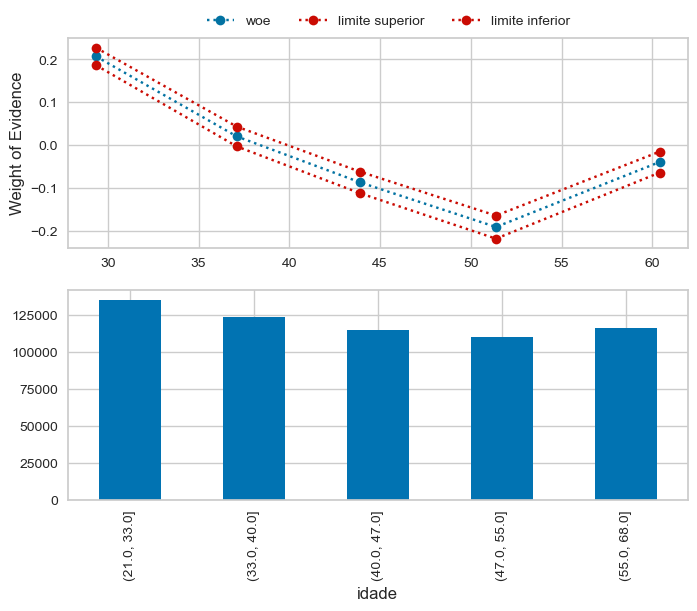

In [44]:
biv_continua('idade', 5, df_train)

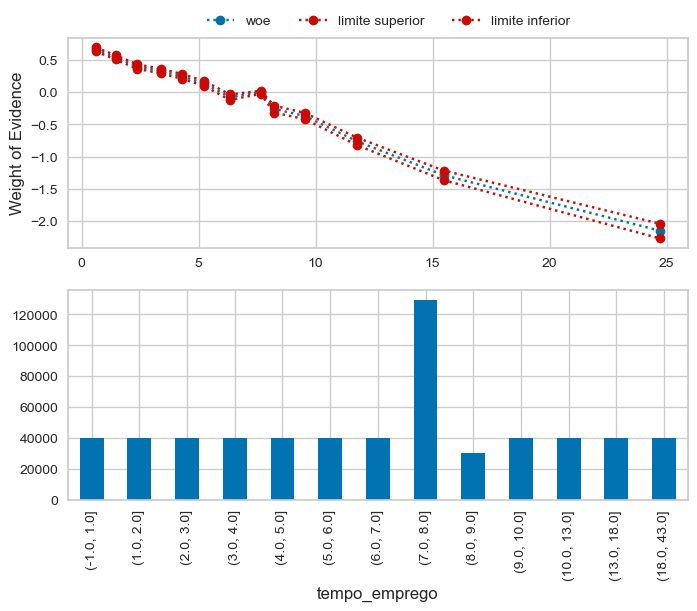

In [45]:
biv_continua('tempo_emprego', 15, df_train)

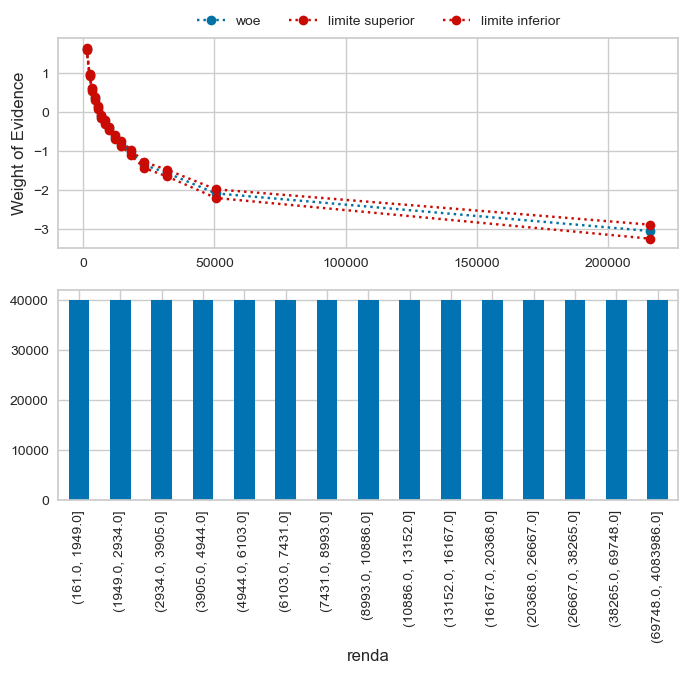

In [46]:
biv_continua('renda', 15, df_train)


In [47]:
# Criando o modelo

formula = '''
    mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + 
    educacao + estado_civil + tipo_residencia + idade + tempo_emprego +
    renda
'''

rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599979
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2488e+05
Date:                Mon, 26 Jun 2023   Deviance:                   2.4965e+05
Time:                        20:15:28   Pearson chi2:                 1.57e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04260
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -1.4189      0.053    -26.825      0.000      -1.523      -1.315
sexo[T.M]                           -0.1255      0.013     -9.567      0.000      -0.151      -0.100
posse_de_veiculo[T.S]                0.0313      0.012      2.529      0.011       0.007       0.056
posse_de_imovel[T.S]                -0.0847      0.012     -7.178      0.000      -0.108      -0.062
tipo_renda[T.Empresário]            -0.0545      0.014     -3.900      0.000      -0.082      -0.027
tipo_renda[T.Pensionista]           -0.0411      0.020     -2.032      0.042      -0.081      -0.001
tipo_renda[T.Servidor público]      -0.0330      0.023     -1.421      0.155      -0.079       0.013
educacao[T.Sup Comp/Pós]            -0.0566      0.013     -4.326      0.000      -0.082      -0.031
estado_civil[T.Separado]             0.0374      0.024      1.574      0.116      -0.009       0.084
estado_civil[T.Solteiro]             0.0054      0.017      0.311      0.756      -0.029       0.039
estado_civil[T.União]                0.0472      0.020      2.322      0.020       0.007       0.087
estado_civil[T.Viúvo]               -0.0346      0.029     -1.192      0.233      -0.092       0.022
tipo_residencia[T.Casa]             -0.0879      0.044     -1.995      0.046      -0.174      -0.002
tipo_residencia[T.Com os pais]      -0.0731      0.050     -1.475      0.140      -0.170       0.024
tipo_residencia[T.Comunitário]      -0.1403      0.089     -1.572      0.116      -0.315       0.035
tipo_residencia[T.Estúdio]          -0.0327      0.082     -0.397      0.691      -0.194       0.129
tipo_residencia[T.Governamental]    -0.0834      0.053     -1.565      0.118      -0.188       0.021
qtd_filhos                           0.0036      0.008      0.448      0.654      -0.012       0.019
idade                                0.0003      0.001      0.394      0.693      -0.001       0.002
tempo_emprego                       -0.0236      0.002    -13.100      0.000      -0.027      -0.020
renda                               -0.0001   1.09e-06    -93.691      0.000      -0.000   -9.96e-05
====================================================================================================
"""

In [48]:
formula = '''
    mau ~ sexo + posse_de_imovel + educacao +
    tempo_emprego + renda
'''

rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599994
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2490e+05
Date:                Mon, 26 Jun 2023   Deviance:                   2.4969e+05
Time:                        20:15:36   Pearson chi2:                 1.59e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04253
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.4931      0.014   -107.439      0.000      -1.520      -1.466
sexo[T.M]                   -0.1072      0.012     -8.926      0.000      -0.131      -0.084
posse_de_imovel[T.S]        -0.0897      0.011     -7.845      0.000      -0.112      -0.067
educacao[T.Sup Comp/Pós]    -0.0569      0.013     -4.477      0.000      -0.082      -0.032
tempo_emprego               -0.0245      0.002    -14.616      0.000      -0.028      -0.021
renda                       -0.0001   1.08e-06    -94.209      0.000      -0.000   -9.96e-05
============================================================================================
"""

In [49]:
formula = '''
    mau ~ sexo + posse_de_imovel + educacao +
    tempo_emprego + renda
'''

rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599994
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2490e+05
Date:                Mon, 26 Jun 2023   Deviance:                   2.4969e+05
Time:                        20:15:43   Pearson chi2:                 1.59e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04253
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -1.4931      0.014   -107.439      0.000      -1.520      -1.466
sexo[T.M]                   -0.1072      0.012     -8.926      0.000      -0.131      -0.084
posse_de_imovel[T.S]        -0.0897      0.011     -7.845      0.000      -0.112      -0.067
educacao[T.Sup Comp/Pós]    -0.0569      0.013     -4.477      0.000      -0.082      -0.032
tempo_emprego               -0.0245      0.002    -14.616      0.000      -0.028      -0.021
renda                       -0.0001   1.08e-06    -94.209      0.000      -0.000   -9.96e-05
============================================================================================
"""

In [50]:
formula = '''
    mau ~ sexo + posse_de_imovel + educacao +
    tempo_emprego + np.log(renda)
'''

rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599994
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2027e+05
Date:                Mon, 26 Jun 2023   Deviance:                   2.4055e+05
Time:                        20:15:50   Pearson chi2:                 5.97e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.05720
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    5.9194      0.051    115.829      0.000       5.819       6.020
sexo[T.M]                   -0.0018      0.012     -0.149      0.882      -0.026       0.022
posse_de_imovel[T.S]        -0.0175      0.012     -1.494      0.135      -0.040       0.005
educacao[T.Sup Comp/Pós]    -0.0056      0.013     -0.430      0.667      -0.031       0.020
tempo_emprego               -0.0010      0.002     -0.610      0.542      -0.004       0.002
np.log(renda)               -0.9881      0.007   -149.914      0.000      -1.001      -0.975
============================================================================================
"""

In [51]:
formula = '''
    mau ~ np.log(renda)
'''

rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599998
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2028e+05
Date:                Mon, 26 Jun 2023   Deviance:                   2.4055e+05
Time:                        20:15:52   Pearson chi2:                 5.97e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.05719
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.9239      0.049    121.382      0.000       5.828       6.020
np.log(renda)    -0.9908      0.006   -169.858      0.000      -1.002      -0.979
=================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

**BASE DE TREINO**

In [52]:
df_train['score'] = rl.predict(df_train)

# Acurácia
acc = metrics.accuracy_score(df_train.mau, df_train.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_train.mau, df_train.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_train.loc[df_train.mau == 1, 'score'], df_train.loc[df_train.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 71.9% 
AUC: 77.0% 
GINI: 54.0%
KS: 39.9%


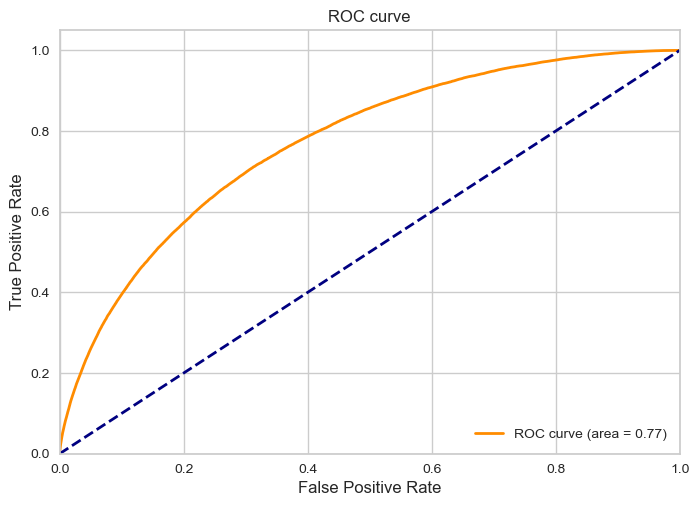

In [53]:
fpr, tpr, thresholds = metrics.roc_curve(df_train['mau'], df_train['score'])

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(df_train['mau'], df_train['score'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

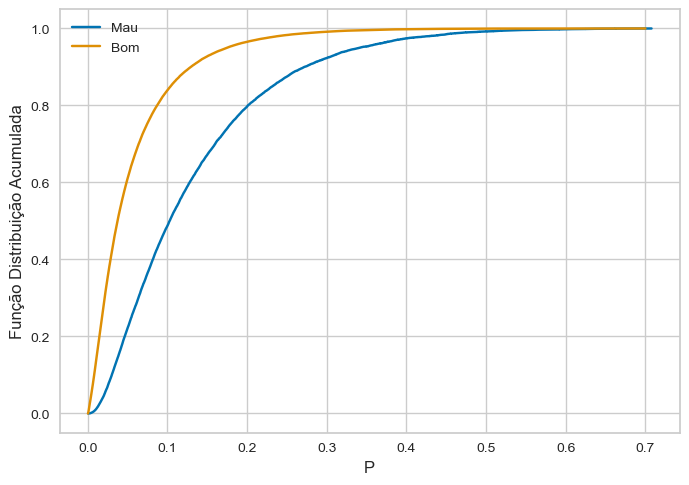

In [54]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

score_pop1 = df_train.loc[df_train['mau']==1,'score']
ax.plot(np.sort(score_pop1), np.linspace(0, 1, len(score_pop1), endpoint=False), label='Mau')

score_pop2 = df_train.loc[df_train['mau']!=1,'score']
ax.plot(np.sort(score_pop2), np.linspace(0, 1, len(score_pop2), endpoint=False), label='Bom')
ax.legend()

ax.set_xlabel('P')
ax.set_ylabel('Função Distribuição Acumulada');

Observações: Obtivemos uma boa acurácia, a curva ROC ficou com uma área maior do que 0.5 o que também é positivo, apesar que um valor próximo de 0.75 seria algo considerado mediano, o gráfico da função distribuição acumulada não está excelente, mas um KS de quase 40% não é de todo ruim.



**BASE DE TESTE "out of time"**



In [55]:
df_test['tempo_emprego'].fillna(value=df_test['tempo_emprego'].mean(), inplace=True)
df_test.educacao.replace({'Fundamental':'Fund/Médio/Sup Incomp', 
                      'Médio':'Fund/Médio/Sup Incomp',
                      'Superior incompleto':'Fund/Médio/Sup Incomp',
                      'Superior completo': 'Sup Comp/Pós',
                      'Pós graduação': 'Sup Comp/Pós'
                     }, inplace=True)

In [56]:
df_test['score'] = rl.predict(df_test)

# Acurácia
acc = metrics.accuracy_score(df_test.mau, df_test.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_test.mau, df_test.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_test.loc[df_test.mau == 1, 'score'], df_test.loc[df_test.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))


Acurácia: 39.3% 
AUC: 73.9% 
GINI: 47.8%
KS: 34.7%


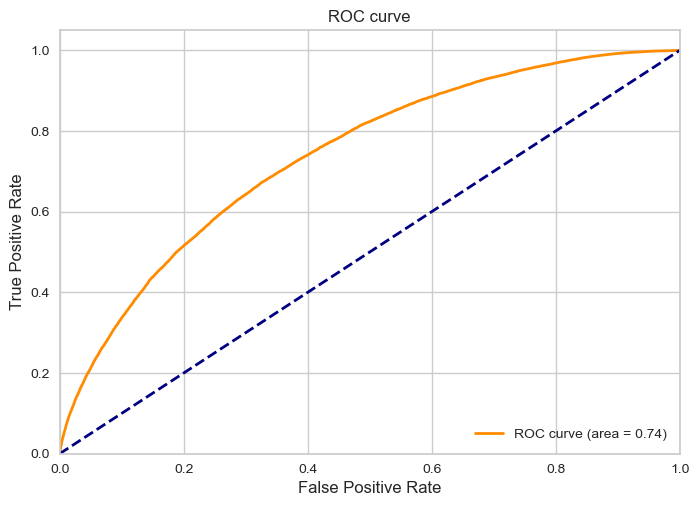

In [57]:
fpr, tpr, thresholds = metrics.roc_curve(df_test['mau'], df_test['score'])

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(df_test['mau'], df_test['score'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

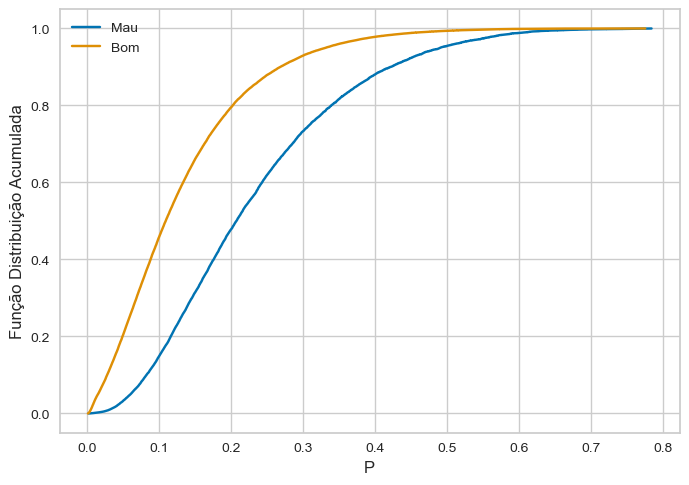

In [58]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

score_pop1 = df_test.loc[df_test['mau']==1,'score']
ax.plot(np.sort(score_pop1), np.linspace(0, 1, len(score_pop1), endpoint=False), label='Mau')

score_pop2 = df_test.loc[df_test['mau']!=1,'score']
ax.plot(np.sort(score_pop2), np.linspace(0, 1, len(score_pop2), endpoint=False), label='Bom')
ax.legend()

ax.set_xlabel('P')
ax.set_ylabel('Função Distribuição Acumulada');

Observações: Apesar de queda considerável no valor da acurácia na base de testes os indicadores AUC, GINI e KS apresentaram pouca variação, portanto, o modelo continua viável.

# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

In [59]:
df = pd.read_feather('credit_scoring.ftr')

df['mau'] = df.mau.astype('int64')

df.drop(columns = ['data_ref', 'index'], axis=1, inplace=True)
df.columns

Index(['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'qtd_filhos',
       'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'idade',
       'tempo_emprego', 'qt_pessoas_residencia', 'renda', 'mau'],
      dtype='object')

In [60]:
df.shape

(750000, 13)

In [61]:
# Reduzindo o DataFrame para que o código rode mais rápido

dataset = df.sample(n=50000, random_state=999)

data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (47500, 13)
Conjunto de dados não usados no treino/teste, apenas como validação: (2500, 13)


In [97]:
data.shape

(47500, 13)

## Pré processamento

In [63]:
# Classificando os dados numéricos e categóricos

numeric_features = df.select_dtypes(include='number').columns.drop('mau').tolist()
categorical_features = df.select_dtypes(exclude='number').columns.tolist()

numeric_features

['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

In [64]:
categorical_features

['sexo',
 'posse_de_veiculo',
 'posse_de_imovel',
 'tipo_renda',
 'educacao',
 'estado_civil',
 'tipo_residencia']

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [65]:
exp_clf101 = setup(data = data, target = 'mau', session_id=123) 

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(47500, 13)"
4,Transformed data shape,"(47500, 30)"
5,Transformed train set shape,"(33250, 30)"
6,Transformed test set shape,"(14250, 30)"
7,Ordinal features,3
8,Numeric features,5
9,Categorical features,7


In [66]:
data.isnull().sum()

sexo                        0
posse_de_veiculo            0
posse_de_imovel             0
qtd_filhos                  0
tipo_renda                  0
educacao                    0
estado_civil                0
tipo_residencia             0
idade                       0
tempo_emprego            7916
qt_pessoas_residencia       0
renda                       0
mau                         0
dtype: int64

In [67]:
data.dtypes

sexo                      object
posse_de_veiculo          object
posse_de_imovel           object
qtd_filhos                 int64
tipo_renda                object
educacao                  object
estado_civil              object
tipo_residencia           object
idade                      int64
tempo_emprego            float64
qt_pessoas_residencia    float64
renda                    float64
mau                        int64
dtype: object

**R. Existem dados nulos na variável numérica "tempo_emprego "(vide item 10 Rows with missing values 16.7%) e serão substituídos pela média.**

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [68]:
# o identificando e removendo ouliers
exp_clf102 = setup(data = data, target = 'mau', remove_outliers = True, session_id=123) 

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(47500, 13)"
4,Transformed data shape,"(45837, 30)"
5,Transformed train set shape,"(31587, 30)"
6,Transformed test set shape,"(14250, 30)"
7,Ordinal features,3
8,Numeric features,5
9,Categorical features,7


**R. As linhas foram removidas como se observa da diferença entre o "Original data shape (47500,12)" e "Transformed data shape (45837,30)".**

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [69]:
clf1 = setup(data = data, target = 'mau', feature_selection = True, feature_selection_method = 'classic')

,Description,Value
0,Session id,4420
1,Target,mau
2,Target type,Binary
3,Original data shape,"(47500, 13)"
4,Transformed data shape,"(47500, 3)"
5,Transformed train set shape,"(33250, 3)"
6,Transformed test set shape,"(14250, 3)"
7,Ordinal features,3
8,Numeric features,5
9,Categorical features,7


In [70]:
clf2 = setup(data = data, target = 'mau', feature_selection = True, feature_selection_method = 'sequential')

,Description,Value
0,Session id,6863
1,Target,mau
2,Target type,Binary
3,Original data shape,"(47500, 13)"
4,Transformed data shape,"(47500, 3)"
5,Transformed train set shape,"(33250, 3)"
6,Transformed test set shape,"(14250, 3)"
7,Ordinal features,3
8,Numeric features,5
9,Categorical features,7


In [71]:
clf3 = setup(data = data, target = 'mau', feature_selection = True, feature_selection_method = 'univariate')

,Description,Value
0,Session id,6237
1,Target,mau
2,Target type,Binary
3,Original data shape,"(47500, 13)"
4,Transformed data shape,"(47500, 3)"
5,Transformed train set shape,"(33250, 3)"
6,Transformed test set shape,"(14250, 3)"
7,Ordinal features,3
8,Numeric features,5
9,Categorical features,7


### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [73]:
exp_clf102 = setup(data = data, target = 'mau', remove_outliers = True, 
                   pca = True, pca_components = 5, session_id=123) 

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(47500, 13)"
4,Transformed data shape,"(45837, 6)"
5,Transformed train set shape,"(31587, 6)"
6,Transformed test set shape,"(14250, 6)"
7,Ordinal features,3
8,Numeric features,5
9,Categorical features,7


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [74]:
data_dm = pd.get_dummies(data)
data_dm

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,sexo_F,sexo_M,posse_de_veiculo_N,posse_de_veiculo_S,...,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Aluguel,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,0,27,8.361644,1.0,12157.95,0,1,0,1,0,...,0,1,0,0,0,0,1,0,0,0
1,0,28,3.449315,2.0,15356.01,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
2,0,28,6.676712,2.0,2394.27,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,0,38,7.808219,2.0,10683.96,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,1,35,6.624658,3.0,8169.00,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47495,0,53,3.879452,2.0,1406.10,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
47496,0,49,10.043836,2.0,32403.79,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
47497,0,44,8.523288,2.0,14332.47,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
47498,0,44,2.430137,2.0,63131.43,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0


### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [253]:
column_transformer = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [254]:
preprocess = make_pipeline(column_transformer)
preprocess

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('onehotencoder',
                                                                   OneHotEncoder(categories='auto',
                                                                                 drop=None,
                                                                                 dtype=<class 'numpy.float64'>,
                                                                                 handle_unknown='ignore',
                                                                                 max_categories=None,
                                                                                 min_frequency=None,
                                                                                 sparse=False,
                                                                                 sparse_output=True))],
                                                           verbose=False),
                                                  ['sexo', 'posse_de_veiculo',
                                                   'posse_de_imovel',
                                                   'tipo_renda', 'educacao',
                                                   'estado_civil',
                                                   'tipo_residencia'])],
                                   verbose=False,
                                   verbose_feature_names_out=True))],
         verbose=False)

In [77]:
%%time

exp_clf = setup(data, 
                target = 'mau', 
                session_id=123, 
                numeric_features = numeric_features,
                categorical_features = categorical_features,
                numeric_imputation = True,
                categorical_imputation = 'mode',
                polynomial_features = True,
                normalize = True,
                fix_imbalance = True,
                remove_outliers = True,
                outliers_threshold = 0.02,
                feature_selection = True,
                n_features_to_select = 5,
                pca = True, 
                pca_components = 5) 

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(47500, 13)"
4,Transformed data shape,"(74350, 6)"
5,Transformed train set shape,"(60100, 6)"
6,Transformed test set shape,"(14250, 6)"
7,Ordinal features,3
8,Numeric features,5
9,Categorical features,7


CPU times: total: 8.94 s
Wall time: 3.51 s


# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [102]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [103]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [101]:
lgbm_model = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8144,0.6570,0.2840,0.1443,0.1913,0.0990,0.1063
1,0.8132,0.6550,0.2802,0.1417,0.1882,0.0954,0.1025
2,0.8051,0.6612,0.2840,0.1359,0.1839,0.0886,0.0964
3,0.7955,0.6565,0.3113,0.1372,0.1905,0.0932,0.1035
4,0.8093,0.6582,0.2374,0.1222,0.1614,0.0661,0.0707
5,0.8129,0.6402,0.2802,0.1415,0.1880,0.0950,0.1021
6,0.7865,0.5894,0.2257,0.1019,0.1404,0.0380,0.0419
7,0.7979,0.6217,0.2403,0.1152,0.1558,0.0569,0.0618
8,0.8069,0.6400,0.2713,0.1336,0.1790,0.0837,0.0905


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

**Gerando os Gráficos:**

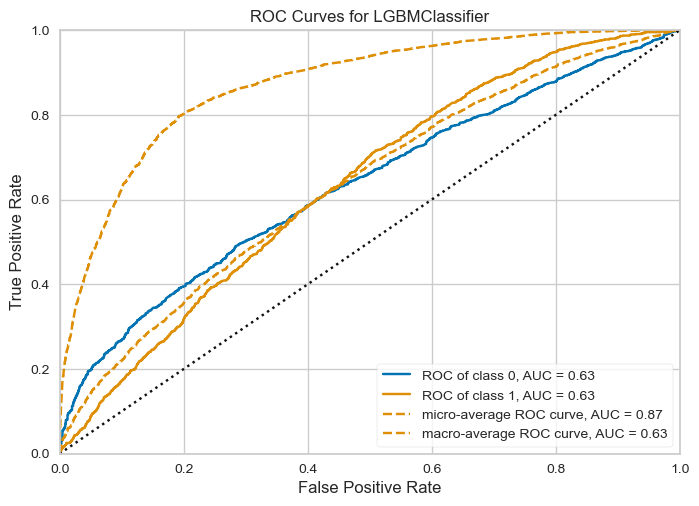

In [104]:
# AUC
plot_model(lgbm_model, plot = 'auc')

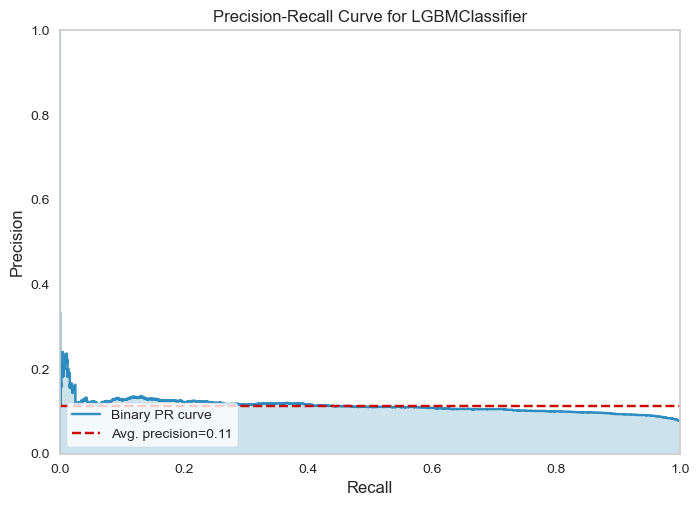

In [105]:
# Precision-Recall Plot
plot_model(lgbm_model, plot = 'pr')

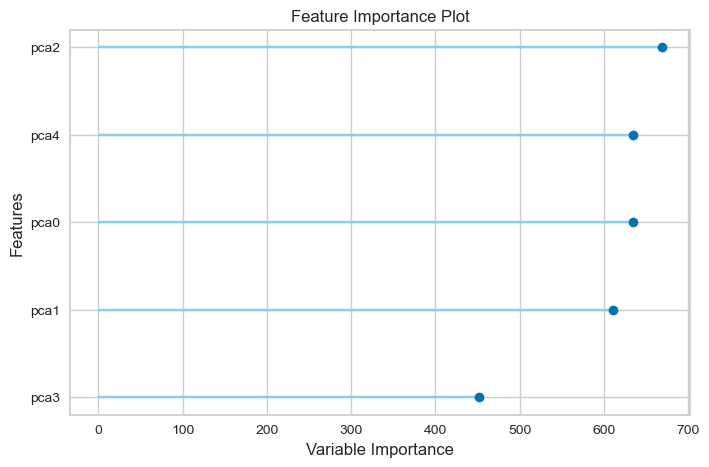

In [83]:
#Feature Importance Plot

plot_model(lgbm_model, plot = 'feature')

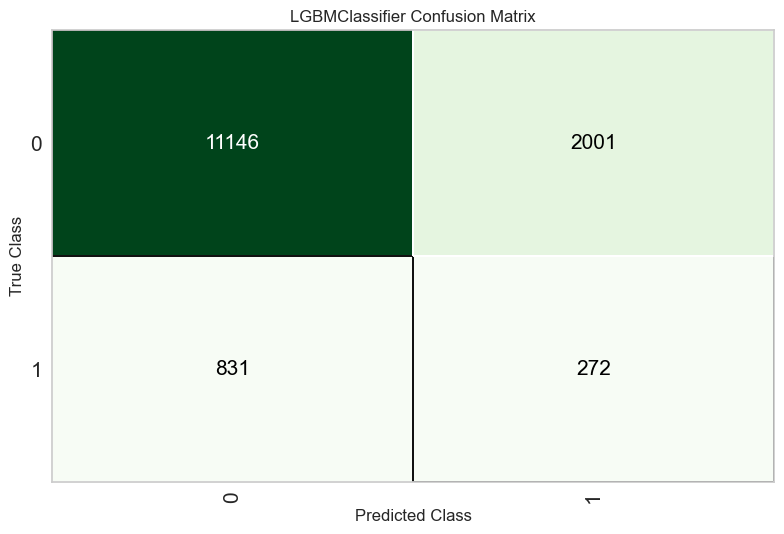

In [89]:
# Matriz de Confusão

plot_model(lgbm_model, plot = 'confusion_matrix')

In [106]:
# Aplicando predict na amostra de validação:

predict_model(lgbm_model);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8013,0.6347,0.2466,0.1197,0.1611,0.0635,0.0689


In [107]:
# Finalizando o modelo para Deploy:

final_lgbm = finalize_model(lgbm_model)

In [108]:
print(final_lgbm)

Pipeline(memory=FastMemory(location=C:\Users\feldb\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=True,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='consta...
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importan

In [109]:
predict_model(final_lgbm);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.4625,0.5901,0.6927,0.0945,0.1663,0.0348,0.0733


In [112]:
# Predizendo o conjunto de dados que não foi usado no treino:

unseen_predictions = predict_model(final_lgbm, data_unseen)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8100,0.6495,0.2897,0.1610,0.2070,0.1090,0.1150


In [113]:
unseen_predictions.head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
0,M,S,S,1,Assalariado,Médio,Casado,Casa,29,3.934247,3.0,24058.269531,0,0,0.6561
1,M,N,N,1,Assalariado,Médio,Casado,Com os pais,25,5.298630,3.0,4157.000000,0,0,0.7536
2,M,S,S,1,Assalariado,Médio,Casado,Casa,38,6.068493,3.0,6271.189941,0,0,0.6815
3,F,N,N,1,Empresário,Superior incompleto,Casado,Com os pais,32,7.561644,3.0,8513.190430,0,0,0.5935
4,F,N,S,0,Pensionista,Médio,União,Casa,55,NaN,2.0,5703.330078,0,0,0.7257


In [99]:
# Salvando o modelo final:

save_model(final_lgbm,'Final LGBM Model 22Nov2022')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\feldb\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=True,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='consta...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree

In [100]:
# Carregando o modelo salvo:

saved_final_lgbm = load_model('Final LGBM Model 22Nov2022')
saved_final_lgbm.named_steps


Transformation Pipeline and Model Successfully Loaded


{'numerical_imputer': TransformerWrapper(exclude=None,
                    include=['qtd_filhos', 'idade', 'tempo_emprego',
                             'qt_pessoas_residencia', 'renda'],
                    transformer=SimpleImputer(add_indicator=False, copy=True,
                                              fill_value=True,
                                              keep_empty_features=False,
                                              missing_values=nan,
                                              strategy='constant',
                                              verbose='deprecated')),
 'categorical_imputer': TransformerWrapper(exclude=None,
                    include=['sexo', 'posse_de_veiculo', 'posse_de_imovel',
                             'tipo_renda', 'educacao', 'estado_civil',
                             'tipo_residencia'],
                    transformer=SimpleImputer(add_indicator=False, copy=True,
                                              fill_value=None,
 